<a href="https://colab.research.google.com/github/WanjaoColins/Exploring_the_Effectiveness_of_Query_Expansion_in_Document_Retrieval/blob/main/Exploring_the_Effectiveness_of_Query_Expansion_in_Document_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install openai
!pip install chromadb
!pip install pypdf
!pip install langchain
!pip install langchain_community
!pip install openai==0.28.0
!pip install langchain-huggingface
!pip install sentence_transformers
!pip install umap-learn
!pip install matplotlib
!pip install pypdf
!pip install tiktoken
!pip install umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=fa9f8aca8bb7036a9407be7c226ac8480267e81671f75d008b95db3fc0f32d56
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [7]:
import chromadb
import openai
from pypdf import PdfReader
import numpy as np
import matplotlib.pyplot as plt
import umap
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter
)
from typing import List, Dict, Any
from dataclasses import dataclass
from functools import lru_cache

In [8]:
@dataclass
class RAGConfig:
    chunk_size: int = 500
    chunk_overlap: int = 100
    tokens_per_chunk: int = 128
    token_overlap: int = 50
    retrieval_k: int = 5
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"

In [9]:
class DocumentProcessor:
    def __init__(self, config: RAGConfig):
        self.config = config
        self.character_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", ".", "!", "?"],
            chunk_size=config.chunk_size,
            chunk_overlap=config.chunk_overlap,
            length_function=len,
        )
        self.token_splitter = SentenceTransformersTokenTextSplitter(
            chunk_overlap=config.token_overlap,
            tokens_per_chunk=config.tokens_per_chunk
        )

    def process_pdf(self, pdf_path: str) -> List[str]:
        reader = PdfReader(pdf_path)
        pdf_texts = [p.extract_text().strip() for p in reader.pages]
        pdf_texts = [text for text in pdf_texts if text]

        character_split_texts = self.character_splitter.split_text("\n\n".join(pdf_texts))

        token_splits_texts = []
        for text in character_split_texts:
            token_splits_texts.extend(self.token_splitter.split_text(text))

        return token_splits_texts

In [23]:
class RAGSystem:
    def __init__(self, config: RAGConfig, openai_api_key: str = None):
        """
        Initializes the RAG system with configuration and optional OpenAI API key.

        Parameters:
        - config: RAGConfig object containing configuration settings.
        - openai_api_key: Optional string for OpenAI API key. Can be set later.
        """
        self.config = config
        self.embeddings = HuggingFaceEmbeddings(model_name=config.model_name)
        self.vectorstore = None
        self.openai_api_key = openai_api_key

    def set_openai_api_key(self, api_key: str):
        """
        Sets or updates the OpenAI API key.

        Parameters:
        - api_key: OpenAI API key as a string.
        """
        self.openai_api_key = api_key

    def initialize_vectorstore(self, texts: List[str], persist_directory: str = "./chroma_db"):
        """
        Initializes the Chroma vectorstore with provided texts.

        Parameters:
        - texts: List of strings to add to the vectorstore.
        - persist_directory: Directory for persisting the vectorstore.
        """
        self.vectorstore = Chroma(
            collection_name="my_collection",
            embedding_function=self.embeddings,
            persist_directory=persist_directory
        )
        self.vectorstore.add_texts(
            texts=texts,
            ids=[str(i) for i in range(len(texts))]
        )

    @lru_cache(maxsize=128)
    def expand_query(self, query: str) -> List[str]:
        """
        Expands the given query using OpenAI API.

        Parameters:
        - query: Input query string.

        Returns:
        - List of expanded queries including the original query.
        """
        if not self.openai_api_key:
            raise ValueError("OpenAI API key is not set. Use `set_openai_api_key` to provide a valid key.")

        # Set the OpenAI API key
        openai.api_key = self.openai_api_key

        messages = [
            {
                "role": "system",
                "content": (
                    "You are a query expansion specialist. Generate 3 alternative versions of the user's query "
                    "that maintain the same intent but use different wording or add relevant context. "
                    "Return ONLY the alternative queries, one per line."
                )
            },
            {"role": "user", "content": query}
        ]

        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.7,
            max_tokens=100
        )

        return [query] + response['choices'][0]['message']['content'].strip().split('\n')

    def retrieve_chunks(self, query: str, use_expansion: bool = False) -> List[Any]:
        if use_expansion:
            expanded_queries = self.expand_query(query)
            all_chunks = []
            seen_content = set()

            for expanded_query in expanded_queries:
                chunks = self.vectorstore.as_retriever(
                    search_type="similarity",
                    search_kwargs={"k": self.config.retrieval_k}
                ).invoke(expanded_query)

                for chunk in chunks:
                    if chunk.page_content not in seen_content:
                        seen_content.add(chunk.page_content)
                        all_chunks.append(chunk)

            return all_chunks, expanded_queries
        else:
            chunks = self.vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={"k": self.config.retrieval_k}
            ).invoke(query)
            return chunks, [query]

In [17]:
# import umap.umap_ as umap
# class Visualizer:
#     def __init__(self, embeddings):
#         self.embeddings = embeddings
#         self.reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

#     def prepare_embeddings(self, queries: List[str], chunks: List[Any], vectorstore: Any) -> Dict[str, np.ndarray]:
#         query_embeddings = np.vstack([
#             np.array(self.embeddings.embed_query(q)).reshape(1, -1)
#             for q in queries
#         ])

#         chunk_embeddings = np.vstack([
#             np.array(self.embeddings.embed_query(doc.page_content)).reshape(1, -1)
#             for doc in chunks
#         ])

#         all_docs = vectorstore.get()
#         other_embeddings = np.vstack([
#             np.array(self.embeddings.embed_query(text)).reshape(1, -1)
#             for text in all_docs['documents']
#         ])

#         return {
#             'queries': query_embeddings,
#             'chunks': chunk_embeddings,
#             'others': other_embeddings
#         }

#     def plot_embeddings(self, embeddings_dict: Dict[str, np.ndarray],
#                        use_expansion: bool = False):
#         combined_embeddings = np.vstack([
#             embeddings_dict['queries'],
#             embeddings_dict['chunks'],
#             embeddings_dict['others']
#         ])

#         embedding_2d = self.reducer.fit_transform(combined_embeddings)

#         n_queries = len(embeddings_dict['queries'])
#         n_chunks = len(embeddings_dict['chunks'])

#         self._create_plot(
#             embedding_2d,
#             n_queries,
#             n_chunks,
#             use_expansion
#         )

#     def _create_plot(self, embedding_2d, n_queries, n_chunks, use_expansion):
#         query_points = embedding_2d[:n_queries]
#         chunk_points = embedding_2d[n_queries:n_queries + n_chunks]
#         other_points = embedding_2d[n_queries + n_chunks:]

#         plt.figure(figsize=(12, 8))

#         # Plot components
#         plt.scatter(other_points[:, 0], other_points[:, 1],
#                    c='lightgray', s=30, alpha=0.5, label='Other Documents')
#         plt.scatter(chunk_points[:, 0], chunk_points[:, 1],
#                    c='blue', s=100, alpha=0.6, label='Relevant Chunks')

#         colors = ['red', 'orange', 'yellow', 'green']
#         for i, point in enumerate(query_points):
#             label = 'Original Query' if i == 0 else f'Expanded Query {i}'
#             plt.plot(point[0], point[1], 'x', color=colors[i % len(colors)],
#                     markersize=15, markeredgewidth=3, label=label)

#             circle = plt.Circle((point[0], point[1]), 0.2,
#                               color=colors[i % len(colors)], fill=False, alpha=0.3)
#             plt.gca().add_patch(circle)

#             for chunk_point in chunk_points:
#                 plt.plot([point[0], chunk_point[0]],
#                         [point[1], chunk_point[1]],
#                         'k--', alpha=0.1)

#         plt.title('UMAP Visualization with{} Query Expansion'.format(
#             '' if use_expansion else 'out'))
#         plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
#         plt.show()

In [33]:
import numpy as np
from typing import List, Any, Dict

class Visualizer:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

    def prepare_embeddings(self, queries: List[str], chunks: List[Any], vectorstore: Any) -> Dict[str, np.ndarray]:
        query_embeddings = np.vstack([
            np.array(self.embeddings.embed_query(q)).reshape(1, -1)
            for q in queries
        ])

        chunk_embeddings = np.vstack([
            np.array(self.embeddings.embed_query(doc.page_content)).reshape(1, -1)
            for doc in chunks
        ])

        all_docs = vectorstore.get()
        other_embeddings = np.vstack([
            np.array(self.embeddings.embed_query(text)).reshape(1, -1)
            for text in all_docs['documents']
        ])

        return {
            'queries': query_embeddings,
            'chunks': chunk_embeddings,
            'others': other_embeddings
        }

    def plot_embeddings(self, embeddings_dict: Dict[str, np.ndarray],
                        use_expansion: bool = False, zoom_on: str = "all"):
        """
        Plots the UMAP embeddings with optional zoom functionality.

        Parameters:
        - embeddings_dict: A dictionary containing embeddings for queries, chunks, and others.
        - use_expansion: Whether query expansion was applied.
        - zoom_on: 'queries', 'chunks', 'all', or 'none' to adjust zoom level.
        """
        combined_embeddings = np.vstack([
            embeddings_dict['queries'],
            embeddings_dict['chunks'],
            embeddings_dict['others']
        ])

        embedding_2d = self.reducer.fit_transform(combined_embeddings)

        n_queries = len(embeddings_dict['queries'])
        n_chunks = len(embeddings_dict['chunks'])

        self._create_plot(
            embedding_2d,
            n_queries,
            n_chunks,
            use_expansion,
            zoom_on
        )

    def _create_plot(self, embedding_2d, n_queries, n_chunks, use_expansion, zoom_on):
        query_points = embedding_2d[:n_queries]
        chunk_points = embedding_2d[n_queries:n_queries + n_chunks]
        other_points = embedding_2d[n_queries + n_chunks:]

        plt.figure(figsize=(12, 8))

        # Plot components
        plt.scatter(other_points[:, 0], other_points[:, 1],
                    c='lightgray', s=30, alpha=0.5, label='Other Documents')
        plt.scatter(chunk_points[:, 0], chunk_points[:, 1],
                    c='blue', s=100, alpha=0.6, label='Relevant Chunks')

        colors = ['red', 'orange', 'yellow', 'green']
        for i, point in enumerate(query_points):
            label = 'Original Query' if i == 0 else f'Expanded Query {i}'
            plt.plot(point[0], point[1], 'x', color=colors[i % len(colors)],
                     markersize=15, markeredgewidth=3, label=label)

            circle = plt.Circle((point[0], point[1]), 0.2,
                                color=colors[i % len(colors)], fill=False, alpha=0.3)
            plt.gca().add_patch(circle)

            for chunk_point in chunk_points:
                plt.plot([point[0], chunk_point[0]],
                         [point[1], chunk_point[1]],
                         'k--', alpha=0.1)

        # Add zooming logic
        if zoom_on == "queries":
            x_min, x_max = np.min(query_points[:, 0]) - 0.5, np.max(query_points[:, 0]) + 0.5
            y_min, y_max = np.min(query_points[:, 1]) - 0.5, np.max(query_points[:, 1]) + 0.5
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
        elif zoom_on == "chunks":
            x_min, x_max = np.min(chunk_points[:, 0]) - 0.5, np.max(chunk_points[:, 0]) + 0.5
            y_min, y_max = np.min(chunk_points[:, 1]) - 0.5, np.max(chunk_points[:, 1]) + 0.5
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
        elif zoom_on == "all":
            x_min = min(np.min(query_points[:, 0]), np.min(chunk_points[:, 0])) - 0.5
            x_max = max(np.max(query_points[:, 0]), np.max(chunk_points[:, 0])) + 0.5
            y_min = min(np.min(query_points[:, 1]), np.min(chunk_points[:, 1])) - 0.5
            y_max = max(np.max(query_points[:, 1]), np.max(chunk_points[:, 1])) + 0.5
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)

        # Customize and show plot
        plt.title('UMAP Visualization with{} Query Expansion'.format(
            '' if use_expansion else 'out'))
        plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics.pairwise import cosine_similarity


class QueryChunkDistanceVisualizer:
    def __init__(self, embeddings):
        """
        Initializes the visualizer with the embeddings model.

        Parameters:
        - embeddings: HuggingFaceEmbeddings object to compute embeddings.
        """
        self.embeddings = embeddings

    def compute_distances(self, queries: List[str], chunks: List[Any]) -> Dict[str, List[float]]:
        """
        Computes cosine similarities between queries and chunks.

        Parameters:
        - queries: List of query strings.
        - chunks: List of chunk objects (documents or texts).

        Returns:
        - A dictionary with keys as query indices and values as lists of distances.
        """
        # Compute embeddings for queries
        query_embeddings = np.vstack([
            np.array(self.embeddings.embed_query(query)).reshape(1, -1) for query in queries
        ])

        # Compute embeddings for chunks
        chunk_embeddings = np.vstack([
            np.array(self.embeddings.embed_query(chunk.page_content)).reshape(1, -1) for chunk in chunks
        ])

        # Compute cosine similarities
        similarities = cosine_similarity(query_embeddings, chunk_embeddings)

        # Convert similarities to distances (1 - similarity)
        distances = 1 - similarities

        return {f"Query {i}": list(distances[i]) for i in range(len(queries))}

    def plot_distances(self, distances: Dict[str, List[float]], use_expansion: bool = False):
        """
        Visualizes the distances between queries and chunks.

        Parameters:
        - distances: Dictionary of distances with query indices as keys and chunk distances as values.
        - use_expansion: Boolean indicating whether query expansion was used.
        """
        plt.figure(figsize=(12, 6))

        # Plot distances for each query
        for query_idx, dist_list in distances.items():
            plt.plot(
                range(1, len(dist_list) + 1),
                dist_list,
                marker="o",
                label=query_idx
            )

        plt.title(f"Query-to-Chunk Distances with{'out' if not use_expansion else ''} Query Expansion")
        plt.xlabel("Chunk Index")
        plt.ylabel("Distance (1 - Cosine Similarity)")
        plt.xticks(range(1, len(distances[list(distances.keys())[0]]) + 1))
        plt.legend(title="Queries", loc="upper right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


In [18]:
# 1. Set up the configuration
config = RAGConfig(
    chunk_size=500,
    chunk_overlap=100,
    tokens_per_chunk=128,
    token_overlap=50,
    retrieval_k=5,
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# 2. Initialize the document processor and process the PDF
doc_processor = DocumentProcessor(config)
text_chunks = doc_processor.process_pdf("/content/ITS-Handbook.pdf")

# 3. Initialize the RAG system
rag_system = RAGSystem(config)
rag_system.initialize_vectorstore(text_chunks)

# 4. Initialize the visualizer
visualizer = Visualizer(rag_system.embeddings)

In [15]:
# !pip uninstall umap -y

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1


In [16]:
# !pip install umap-learn

In [ ]:
# 1. First, set up the basic components
config = RAGConfig()
doc_processor = DocumentProcessor(config)
text_chunks = doc_processor.process_pdf("/content/ITS-Handbook.pdf")

# 2. Initialize RAG system
rag_system = RAGSystem(config)
rag_system.initialize_vectorstore(text_chunks)

# 3. Initialize Visualizer
visualizer = Visualizer(rag_system.embeddings)

# 4. Your query
query = "What encryption standards and practices are recommended by CSC's ITS Department?"

# 5a. Without Query Expansion
# Get chunks and queries (will only be original query)
chunks, queries = rag_system.retrieve_chunks(query, use_expansion=False)

# Prepare embeddings
embeddings_dict = visualizer.prepare_embeddings(queries, chunks, rag_system.vectorstore)

# Visualize
visualizer.plot_embeddings(embeddings_dict, use_expansion=False)

# 5b. With Query Expansion
# Get chunks and expanded queries
exp_chunks, exp_queries = rag_system.retrieve_chunks(query, use_expansion=True)

# Prepare embeddings with expanded queries
exp_embeddings_dict = visualizer.prepare_embeddings(exp_queries, exp_chunks, rag_system.vectorstore)

# Visualize with expansion
visualizer.plot_embeddings(exp_embeddings_dict, use_expansion=True)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


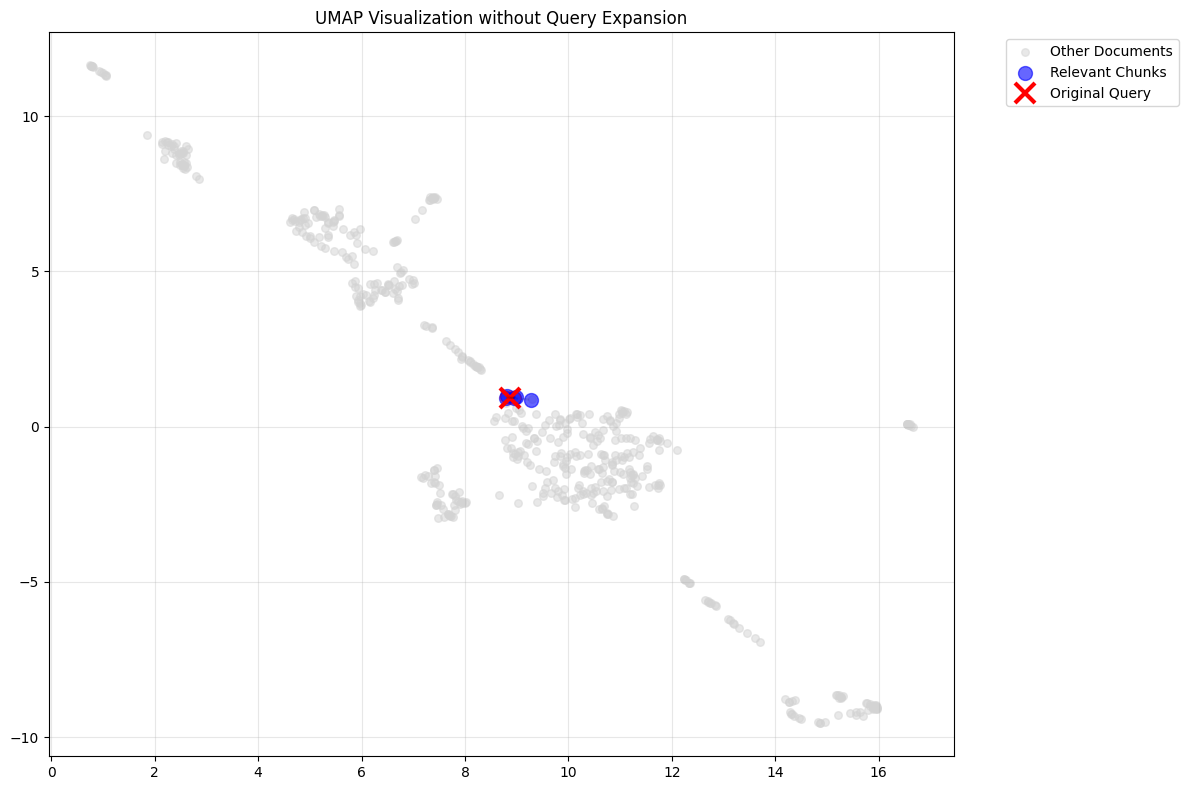

In [21]:
# 4. Your query
query = "What encryption standards and practices are recommended by CSC's ITS Department?"
# 5a. Without Query Expansion
# Get chunks and queries (will only be original query)
chunks, queries = rag_system.retrieve_chunks(query, use_expansion=False)
# Prepare embeddings
embeddings_dict = visualizer.prepare_embeddings(queries, chunks, rag_system.vectorstore)

# Visualize
visualizer.plot_embeddings(embeddings_dict, use_expansion=False)

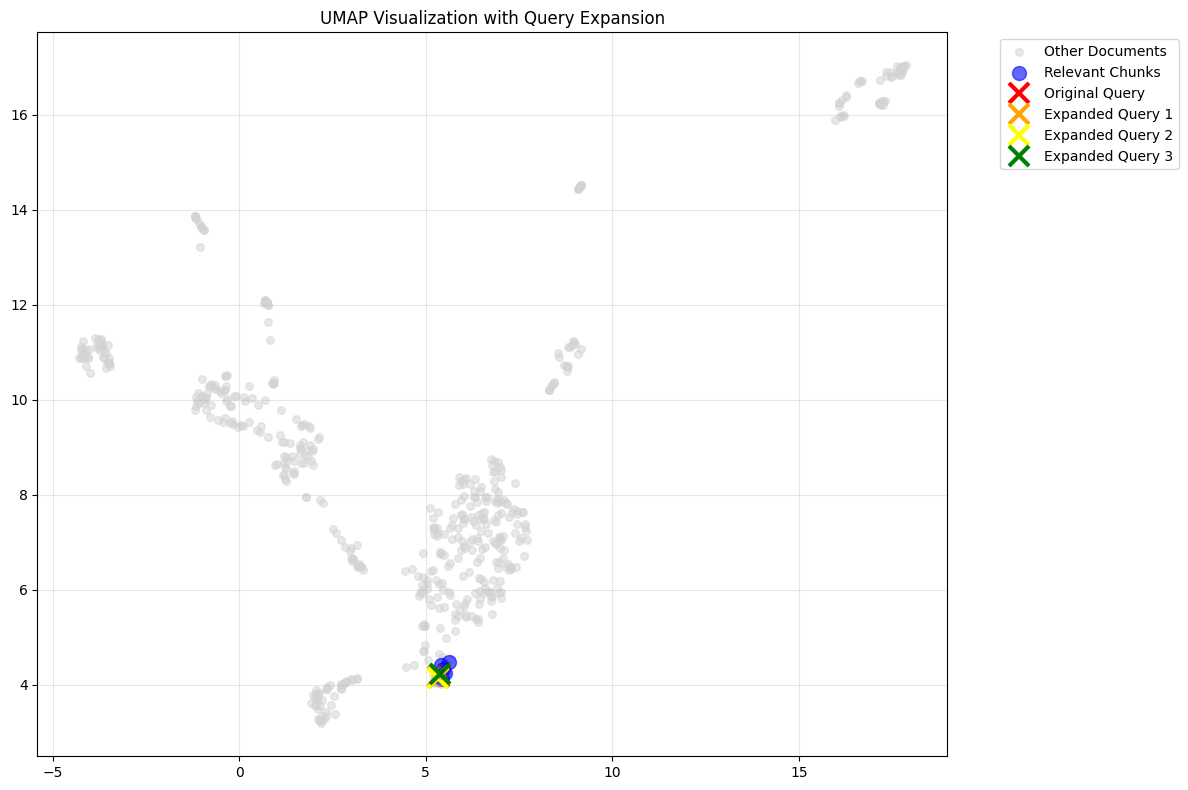

In [36]:
# from google.colab import userdata
# openai_key= userdata.get('API_Key')

# openai.api_key = openai_key

# # 5b. With Query Expansion
# # Get chunks and expanded queries
# exp_chunks, exp_queries = rag_system.retrieve_chunks(query, use_expansion=True)

# # Prepare embeddings with expanded queries
# exp_embeddings_dict = visualizer.prepare_embeddings(exp_queries, exp_chunks, rag_system.vectorstore)

# # Visualize with expansion
visualizer.plot_embeddings(exp_embeddings_dict, use_expansion=True)

In [38]:
# Initialize the distance visualizer
distance_visualizer = QueryChunkDistanceVisualizer(rag_system.embeddings)

In [42]:
# Without Query Expansion
chunks, queries = rag_system.retrieve_chunks(query, use_expansion=True)
distances_without_expansion = distance_visualizer.compute_distances(queries, chunks)
# distance_visualizer.plot_distances(distances_without_expansion, use_expansion=False)

In [43]:
distances_without_expansion

{'Query 0': [0.21164122050001288,
  0.26246394503366943,
  0.26880705610053146,
  0.31653437597448386,
  0.32988418598694014],
 'Query 1': [0.21973487575483375,
  0.29347542380788205,
  0.25584286650948806,
  0.267779340980142,
  0.29403723229277157],
 'Query 2': [0.1915013844493294,
  0.27209264471228356,
  0.2975706161514793,
  0.33542919154155726,
  0.3006872062543706],
 'Query 3': [0.20633323999804576,
  0.30460936334311983,
  0.26438191524594834,
  0.3075678406450233,
  0.3273902491068136]}

In [45]:
chunks, queries = rag_system.retrieve_chunks(query, use_expansion=False)
distances_without_expansion = distance_visualizer.compute_distances(queries, chunks)
print(distances_without_expansion)

{'Query 0': [0.211641220500013, 0.26246394503366943, 0.26880705610053135, 0.31653437597448375, 0.32988418598694014]}


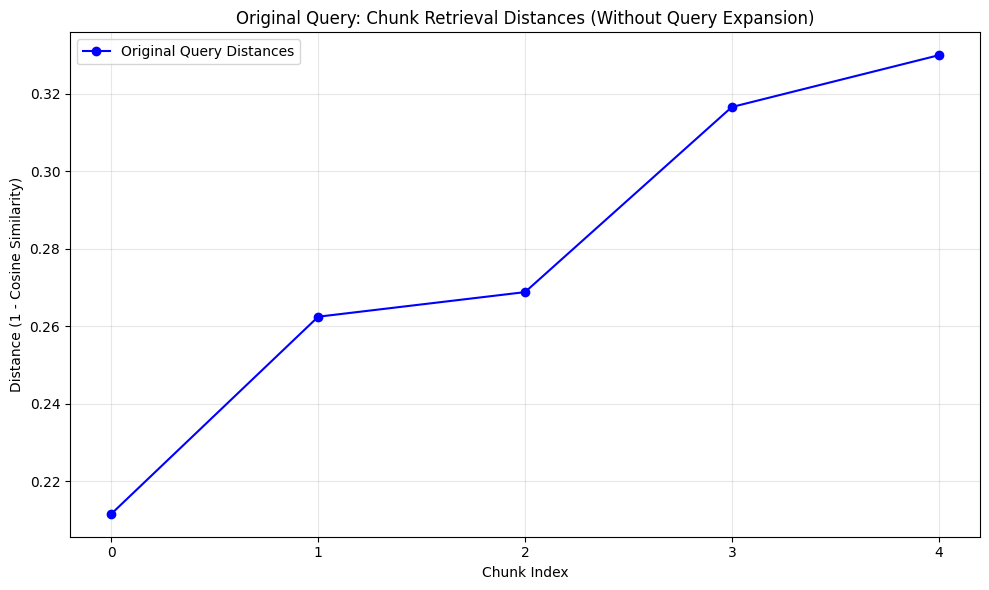

In [52]:

# Visualize the distances for the Original Query
import matplotlib.pyplot as plt

# Distances for Original Query
distances = [0.211641220500013, 0.26246394503366943, 0.26880705610053135, 0.31653437597448375, 0.32988418598694014]

# Plot the distances
plt.figure(figsize=(10, 6))
plt.plot(distances, marker='o', linestyle='-', color='b', label='Original Query Distances')
plt.title('Original Query: Chunk Retrieval Distances (Without Query Expansion)')
plt.xlabel('Chunk Index')
plt.ylabel('Distance (1 - Cosine Similarity)')
plt.xticks(range(len(distances)))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

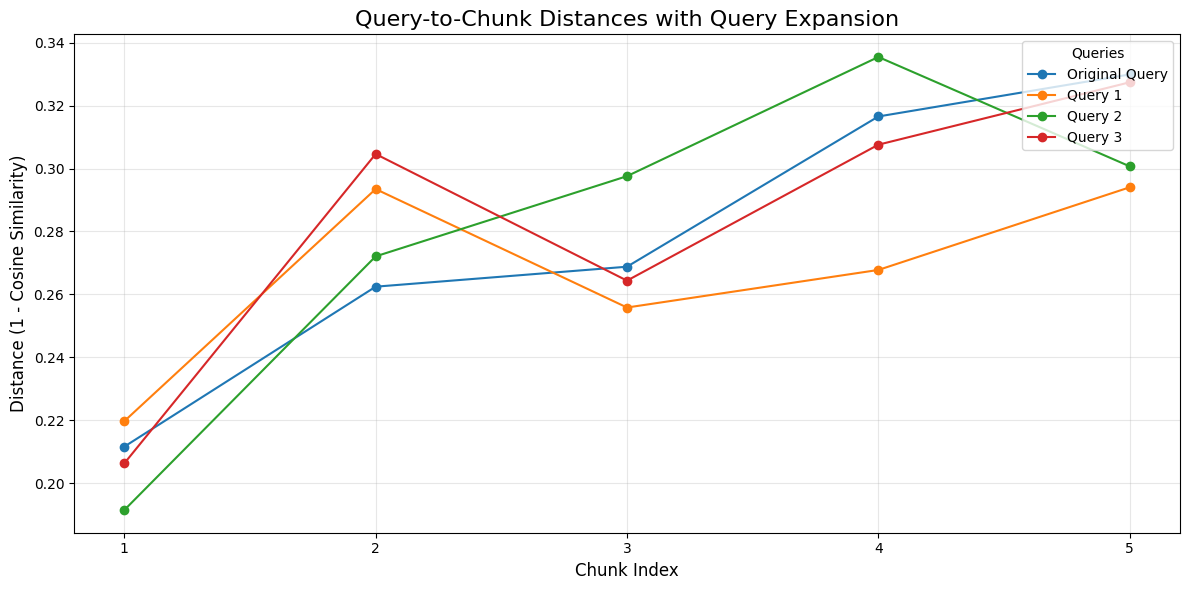

In [51]:
# Distances with query expansion
distances_with_expansion = {
    'Original Query': [0.21164122050001288, 0.26246394503366943, 0.26880705610053146, 0.31653437597448386, 0.32988418598694014],
    'Query 1': [0.21973487575483375, 0.29347542380788205, 0.25584286650948806, 0.267779340980142, 0.29403723229277157],
    'Query 2': [0.1915013844493294, 0.27209264471228356, 0.2975706161514793, 0.33542919154155726, 0.3006872062543706],
    'Query 3': [0.20633323999804576, 0.30460936334311983, 0.26438191524594834, 0.3075678406450233, 0.3273902491068136]
}

# Create a plot
plt.figure(figsize=(12, 6))

# Plot distances for each query
for query, dist_list in distances_with_expansion.items():
    plt.plot(
        range(1, len(dist_list) + 1),  # Chunk indices
        dist_list,
        marker="o",
        label=query
    )

# Customize the plot
plt.title("Query-to-Chunk Distances with Query Expansion", fontsize=16)
plt.xlabel("Chunk Index", fontsize=12)
plt.ylabel("Distance (1 - Cosine Similarity)", fontsize=12)
plt.xticks(range(1, len(distances_with_expansion['Original Query']) + 1))
plt.grid(True, alpha=0.3)
plt.legend(title="Queries", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()


In [53]:
def calculate_average_distance(distances: Dict[str, List[float]]) -> Dict[str, float]:
    """
    Calculate the average distance for each query.

    Parameters:
    - distances: A dictionary where keys are query labels (e.g., 'Query 0')
                 and values are lists of distances for each chunk retrieved.

    Returns:
    - A dictionary where keys are query labels and values are the average distances.
    """
    average_distances = {}

    for query, dist_list in distances.items():
        average_distances[query] = np.mean(dist_list)  # Calculate mean distance for each query

    return average_distances

# Example Usage:
distances_without_expansion = {
    'Original Query': [0.211641220500013, 0.26246394503366943, 0.26880705610053135, 0.31653437597448375, 0.32988418598694014]
}

distances_with_expansion = {
    'Original Query': [0.21164122050001288, 0.26246394503366943, 0.26880705610053146, 0.31653437597448386, 0.32988418598694014],
    'Query 1': [0.21973487575483375, 0.29347542380788205, 0.25584286650948806, 0.267779340980142, 0.29403723229277157],
    'Query 2': [0.1915013844493294, 0.27209264471228356, 0.2975706161514793, 0.33542919154155726, 0.3006872062543706],
    'Query 3': [0.20633323999804576, 0.30460936334311983, 0.26438191524594834, 0.3075678406450233, 0.3273902491068136]
}

# Calculate average distances
avg_distances_without_expansion = calculate_average_distance(distances_without_expansion)
avg_distances_with_expansion = calculate_average_distance(distances_with_expansion)

# Print results
print("Average Distances without Query Expansion:")
for query, avg_distance in avg_distances_without_expansion.items():
    print(f"{query}: {avg_distance:.4f}")

print("\nAverage Distances with Query Expansion:")
for query, avg_distance in avg_distances_with_expansion.items():
    print(f"{query}: {avg_distance:.4f}")

Average Distances without Query Expansion:
Original Query: 0.2779

Average Distances with Query Expansion:
Original Query: 0.2779
Query 1: 0.2662
Query 2: 0.2795
Query 3: 0.2821


#Conclusion

Based on the experimental results comparing document retrieval with and without query expansion, we observe several key findings:
The baseline performance using the original query method yielded an average distance of **0.2779**. When implementing query expansion, we obtained varying results across three different expanded queries:

- Query 1 showed a slight improvement with an average distance of **0.2662**
- Query 2 performed marginally worse with an average distance of **0.2795**
- Query 3 demonstrated the least effective performance with an average distance of **0.2821**

These results suggest that query expansion does not consistently improve document retrieval effectiveness in our implementation. While Query 1 showed promise with a 4.2% improvement over the baseline, the other expanded queries actually led to decreased performance. This inconsistency highlights the challenges in implementing effective query expansion techniques.
The mixed results indicate that the success of query expansion may be highly dependent on the specific terms added and the context of the original query. Future work could focus on:

Developing more sophisticated term selection methods for expansion
- Implementing relevance feedback mechanisms
- Exploring different weighting schemes for expanded terms
- Analyzing the relationship between query characteristics and expansion effectiveness

In summary, while query expansion shows potential for improving document retrieval in specific cases, our findings suggest that careful consideration must be given to the expansion methodology to ensure consistent improvements in retrieval performance.